# Aim
A linear regression analysis is applied to check whether visual network (VIS) and Dorsal Attention Network (DAN) or Default Mode Network (DMN) are hierarchically connected to each other.
# Data analysis order
1. Load all the data (connectivity during attention and resting) : connAtten, connRest
2. Extract only necessary part of the data and reorganize it
 (connectivity between DAN-VIS, DMN-VIS)
3. Linear regression fit : gain, base will be obtained
4. Visualize the Linear Regression plot
5. Visualize the Gain, Base (as a bar plot)

In [1]:
# load libraries (python2)
import pandas as pd
import scipy 
from scipy import mean
from scipy.stats import sem, t
import numpy as np
import scipy.io as sio
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pylab

# Define Basic

In [2]:
# Define basie parameters
n_roi = 24; n_subj = 20

# V1, V2, V3, V4, V5, FEF, IPS, MFC, PCC
all_indx =  [[0,1],[2,3],[4,5],[6],[7],[8],[9],[10],[11]]
conds = ['corrAtten', 'corrRest']
hemis = ['L', 'R']
DXN_Name = ['FEF','IPS','LP','MFC']
colors = ['r','b']
fit_param = ['Gain', 'Base']
n_vis = 5; n_dxn = 4; 
n_conds = len(conds); n_hemi = len(hemis); n_comb = len(all_indx); 
yrange = [-0.1, 0.4]

# Linear Regression X, Y[dxnI]
x = np.arange(n_vis)
dxn_LR_indx = np.arange(n_dxn*2) # FEFL, FEFR, IPSL, IPSR, LPL, LPR, MFC, PCC

# Directory setup
# dir_main = '/Users/soyoung/Python_Stimulus/LinearRegression_Connectivity/'
# dir_connectivity = dir_main + "/01_DataConnectivity/"

dir_main = "/Volumes/SoyoungBackup/Mac_HD3/Atten_Motion_OnOff/LinearRegression_Connectivity/"
dir_connectivity = dir_main + "/01_DataConnectivity/"
 
prefix = "Conn_rand32_craf_regMotionWM_highnone_low0_P_shift20_regMeanSubjVox_sub"
filetype = prefix + "*[!wrong][!retino].mat"

# 1. Load the data

In [3]:
# load connectivity data : conn_group['atten','rest'](n_roi, n_roi, all_subj)
def load_data_group(dir_connectivity, filetype):#, cond):
    conn_group = {}
    # Load the file list
    conn_list = [f for f in glob.glob(dir_connectivity + filetype)]
    
    # Predefine group data and assign it
    for c in range(n_conds):
        conn_group[conds[c]] = np.zeros([n_roi, n_roi, n_subj])
        for s in range(n_subj):
            conn_subj = sio.loadmat(conn_list[s])
            conn_group[conds[c]][:,:,s] = np.mean(conn_subj[conds[c]], axis = 2)
    return conn_group

# 2. Extract & reorganize data
1. Extract Left, Right Data => L-L, L-R, R-R, R-L
2. Extract DAN-VIS, DMN-VIS

In [4]:
# Data combine: dataROIcomb['corrAttenL(R)', 'corrRestL(R)'](n_comb, n_comb, all_subj)
# n_roi -> n_roi/2 -> 9 ROIs
# Reshape into one hemi only (n_roi,n_roi,all_subj) ==> (n_roi/2, n_roi/2, all_subj)
# Combine different ROIs : V1d, V1v ==> V1 (9, 9, all_subj)
def data_reorg_LR_comb(data_both):#, condName, hemi):
    dataROIcomb = {}
    for hemi in hemis:
        for c in conds:
            # predefine result, get the input
            dataROIcomb[c + hemi] = np.zeros([n_comb, n_comb, n_subj])
            data_cond = data_both[c]

            # DAN hemisphere (L : odd, R: even)
            if hemi == 'L': oddeven = 0
            elif hemi == 'R': oddeven = 1
            data_half_test = data_cond[list(range(oddeven, n_roi, 2)), :, :] # DAN hemi (input)
            data_half_XL   = data_half_test[:, list(range(0, n_roi, 2)), :] # VIS hemi(L)
            data_half_XR   = data_half_test[:, list(range(1, n_roi, 2)), :] # VIS hemi(R)

            # combine LL+LR
            dataLR = np.zeros([n_roi/2, n_roi/2, n_subj, 2])
            dataLR[:,:,:,0] = data_half_XL; dataLR[:,:,:,1] = data_half_XR;
            dataLR = np.mean(dataLR, axis=3)  

            # combine different ROIs
            # V1d, V1v = > V1
            for x in range(n_comb):
                for y in range(n_comb):
                    dataROIcomb_temp = np.mean(dataLR[:, all_indx[y], :], axis = 1)
                    dataROIcomb[(c + hemi)][x,y,:] = np.mean(dataROIcomb_temp[all_indx[x], :], axis =0)
    return dataROIcomb

In [5]:
# Extract DAN (or DMN) - VIS only
# DAN(DMN)-VIS (FEF,IPS,PCC,MFC- V1,V2,V3,V4,V5/MT) ==> (4,5,all_subj)
def data_dxn_only(dataROIcomb):
    DXN_VIS = {}
    for hemi in hemis:
        for c in conds:
            # preassign result
            DXN_VIS[c + hemi] = np.zeros([n_dxn, n_vis, n_subj])
            data_cond = dataROIcomb[c + hemi]
            
            # only extract vis Index, DXN index
            All_VIS = data_cond[ :, np.arange(n_vis), :]
            DXN_VIS[c + hemi] = All_VIS[n_vis + np.arange(n_dxn), :, :]
    return DXN_VIS

# 3. Linear Regression
 1. linear fit => Gain, Base, Fitted Y
 2. Gain, Base (L+R combine)

In [6]:
# fit_result['Gain', 'Base', 'Fitted Y']
def linear_regression(X, Y, DXN_Name):   
    fit_result = {}
    for hemi in hemis:
        for c in conds:
            # preassign result
            fit_result['Gain ' + c + hemi] = np.zeros([n_subj, n_dxn])
            fit_result['Base ' + c + hemi] = np.zeros([n_subj, n_dxn])
            fit_result['Fitted Y ' + c + hemi] = np.zeros([n_subj, n_dxn, n_vis])
            
            # assign result
            for dxn in range(n_dxn):
                for s in range(n_subj):
                    Y_pd = pd.DataFrame(Y[c + hemi][dxn, :, s]) # to make pd for linearReg
                    
                    # Fit 
                    lr = LinearRegression()#(normalize=True)
                    lr.fit(X, Y_pd)
                    pred_Y = lr.predict(X)
                    fit_result['Fitted Y ' + c + hemi][s,dxn,0:n_vis] = pred_Y[:,0] # only pred_y value
                    fit_result['Gain ' + c + hemi][s,dxn] = lr.coef_  
                    fit_result['Base '+ c + hemi][s,dxn] = lr.intercept_
    return fit_result

In [7]:
# fit_result => gain, base (L+R comb)
def combine_linear_regress(fit_result):
    gain={}; base={};
    for c in range(len(conds)):
        gain[conds[c]] = np.zeros([n_subj, n_dxn*2]);
        base[conds[c]] = np.zeros([n_subj, n_dxn*2]);
        
        # Gain, Base : combine L + R
        gain[conds[c]][: ,list(range(0,8,2))] = fit_result['Gain ' + conds[c] + 'L']
        gain[conds[c]][: ,list(range(1,8,2))] = fit_result['Gain ' + conds[c] + 'R']
        base[conds[c]][: ,list(range(0,8,2))] = fit_result['Base ' + conds[c] + 'L']
        base[conds[c]][: ,list(range(1,8,2))] = fit_result['Base ' + conds[c] + 'R']
    return gain, base

# 4. Visualize the Linear Regression plot

In [8]:
# Linear Fit (DAN - VIS)
def plt_linear_fit(x, fit_result, indx, fig_name): # indx --> which dxn
    fig = plt.figure(figsize=(8,3))
    # preassign result
    fit = {}; mean_y = {}; sem_y = {}
    for d in range(indx/2, (indx+n_dxn)/2, 1): # FEF/IPS/LP/CC
        for h in range(len(hemis)): # L/R
            roi_nr = (d%2)*2+h+1
            plt.subplot(1,4,roi_nr); roi_name = (DXN_Name[d] + hemis[h])
            plt.title(roi_name)
            for c in range(len(conds)): # Atten/Rest
                fit[conds[c] + roi_name] = linear_result['Fitted Y ' + conds[c] + hemis[h]][ :, d, :]
                mean_y[conds[c] + roi_name] = mean(fit[conds[c] + roi_name], axis = 0)
                sem_y[conds[c] + roi_name] = sem(fit[conds[c] + roi_name], axis = 0)
            
                # plot parameter: DAN vs DMN, Rest vs Atten
                if d/2 < 1: yrange = [-0.1, 0.4] # DAN
                else: yrange = [-0.4, 0.1] # DMN

                # plot mean + SEM
                plt.plot(x, mean_y[conds[c] + roi_name], colors[c] + '--')
                mean_min_sem = mean_y[conds[c] + roi_name]-sem_y[conds[c] + roi_name]
                mean_add_sem = mean_y[conds[c] + roi_name]+sem_y[conds[c] + roi_name]
                plt.fill_between(x, mean_min_sem, mean_add_sem, color = colors[c], alpha =0.3)
                plt.axhline(0, color='k', linestyle = '--', linewidth = 1)        
                plt.ylim(yrange[0], yrange[1])
    fig.set_rasterized(True)    
    plt.show() 
    fig.savefig(fig_name, rasterized = True)
    return mean_y, sem_y, fit                

In [9]:
# # mean & ci plot (DAN - VIS)
# def plt_mean_ci(x, Y, fit_result, indx, fig_name): # indx --> which dxn
#     fig = plt.figure(figsize=(8,3))
#     # preassign result
#     fit = {}; mean_y = {}; sem_y = {}; real_y = {};
#     for d in range(indx/2, (indx+n_dxn)/2, 1): # FEF/IPS/LP/CC
#         for h in range(len(hemis)): # L/R
#             roi_nr = (d%2)*2+h+1
#             plt.subplot(1,4,roi_nr); roi_name = (DXN_Name[d] + hemis[h])
#             plt.title(roi_name)
#             for c in range(len(conds)): # Atten/Rest
#                 fit[conds[c] + roi_name] = linear_result['Fitted Y ' + conds[c] + hemis[h]][ :, d, :]
#                 real_y[conds[c] + roi_name] = mean(Y[conds[c] + hemis[h]][d, :, :], axis = 1)
#                 mean_y[conds[c] + roi_name] = mean(fit[conds[c] + roi_name], axis = 0)
#                 sem_y[conds[c] + roi_name] = sem(fit[conds[c] + roi_name], axis = 0)
            
#                 # plot parameter: DAN vs DMN, Rest vs Atten
#                 if d/2 < 1: yrange = [-0.1, 0.4] # DAN
#                 else: yrange = [-0.4, 0.1] # DMN

#                 # plot linear line 
#                 plt.plot(x, mean_y[conds[c] + roi_name], colors[c] + '--')
#                 mean_min_sem = mean_y[conds[c] + roi_name]-sem_y[conds[c] + roi_name]
#                 mean_add_sem = mean_y[conds[c] + roi_name]+sem_y[conds[c] + roi_name]
                
#                 # plot mean, SEM
#                 plt.errorbar(x, real_y[conds[c] + roi_name], yerr = sem_y[conds[c] + roi_name], color = colors[c], linestyle = '')
#                 plt.axhline(0, color='k', linestyle = '--', linewidth = 1)        
#                 plt.ylim(yrange[0], yrange[1])
#     fig.set_rasterized(True)    
#     plt.show() 
#     return mean_y, sem_y, fit

In [37]:
def plt_mean_ci(x, Y, fit, mean_y, sem_y, indx, fig_name):
    fig = plt.figure(figsize=(8,3))
    for d in range(indx/2, (indx+n_dxn)/2, 1):
        for h in range(len(hemis)):
            roi_nr = (d%2)*2+h+1; roi_name = (DXN_Name[d] + hemis[h])
            plt.subplot(1,4,roi_nr)
            plt.title(roi_name)
            for c in range(len(conds)): # Atten/Rest
                real_y = mean(Y[conds[c] + hemis[h]][d, :, :], axis = 1)
                
                # plot linear line
                plt.plot(x, mean_y[conds[c] + roi_name], colors[c] + '--')
                
                # plot mean, SEM
                plt.errorbar(x, real_y, yerr = sem_y[conds[c] + roi_name], color = colors[c], linestyle = '')
                plt.axhline(0, color='k', linestyle = '--', linewidth = 1)       
                if indx == 0: ymin = yrange[0]; ymax = yrange[1]
                else: ymin = -yrange[1]; ymax = -yrange[0]
                plt.ylim(ymin, ymax)
                plt.xlim(-1, n_vis)

In [29]:
# fit['corrRestLPR'].shape, mean_y['corrRestLPR'].shape 
-yrange[0]

0.1

# 5. Visualize Gain, Base (diff)

In [12]:
# gain/base barplot
def barplot_gain_base(gain_subj, base_subj, indx):
    
    # === index define
    danI = dxn_LR_indx[indx:indx+n_dxn]
    fig = plt.figure(figsize=(8,3))
    
    # condition difference
    gain_diff = gain_subj['corrAtten']-gain_subj['corrRest']
    base_diff = base_subj['corrAtten']-base_subj['corrRest']
    
    #========= GAIN/BASE : barplot ==========#
    for f in range(len(fit_param)): # gain/base
        plt.subplot(1,2,f+1); plt.title(fit_param[f])#'Gain')
        if f==0: fit_diff = gain_diff[ :,danI]# Gain
        elif f==1: fit_diff = base_diff[ :,danI]# Base
        plt.bar(np.arange(n_dxn), np.mean(fit_diff, axis=0),\
                yerr = sem(fit_diff), capsize=3, color='grey', width = 0.5); 
        plt.axhline(0, color='black', linestyle = '--', linewidth = 0.3)
        plt.ylim(-0.15, 0.15)
plt.show()

# Main analysis 

In [13]:
# 1. load conn data
conn_group = load_data_group(dir_connectivity, filetype)

In [14]:
# 2. Extract DATA 
# X: visual area hierarchy, Y: connectivity DAN(DMN) - VIS
data_combined = data_reorg_LR_comb(conn_group)
Y = data_dxn_only(data_combined)
X = pd.DataFrame(x)

In [15]:
# 3. linear regression
linear_result = linear_regression(X, Y, DXN_Name)

In [16]:
# 3.1. combine L+R linear regression
gain, base = combine_linear_regress(linear_result)

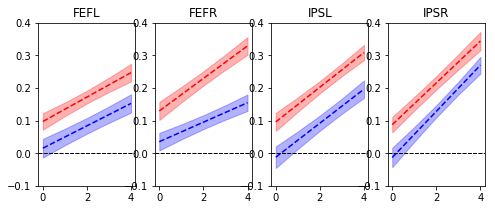

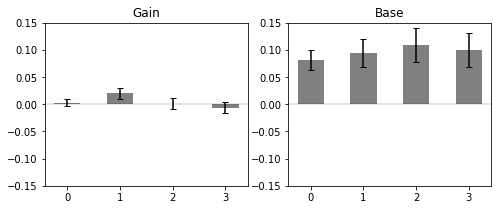

In [17]:
# 4. Visualize linear fit (DAN-VIS) & 5. Gain-Base
[mean_y_DAN, sem_y_DAN, fit_DAN ] = plt_linear_fit(x, linear_result, 0, 'DAN_VIS_LinearFit.eps')
# fig.savefig('DAN_VIS_LinearFit.eps', rasterized = True)
barplot_gain_base(gain, base, 0)
plt.savefig('DAN_VIS_GainBase.eps', format = 'eps', dpi=1000)

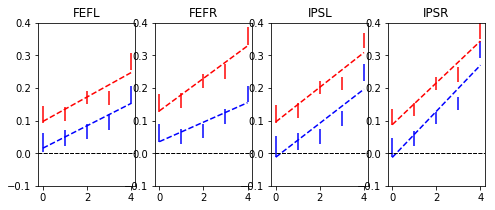

In [18]:
plt_mean_ci(x, Y, fit_DAN, mean_y_DAN, sem_y_DAN, 0, 'DAN_VIS_LinearFit.eps')

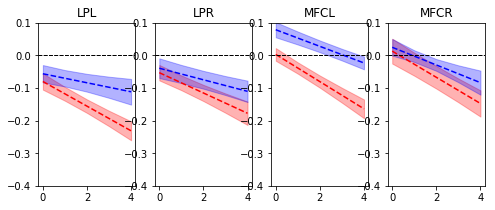

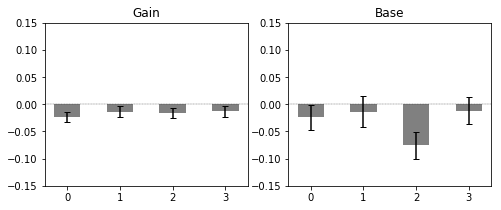

In [19]:
# DMN-VIS
[mean_y_DMN, sem_y_DMN, fit_DMN ] = plt_linear_fit(x, linear_result, n_dxn, 'DMN_VIS_LinearFit.eps')
barplot_gain_base(gain, base, n_dxn)
plt.savefig('DMN_VIS_GainBase.eps', format = 'eps', dpi=1000)

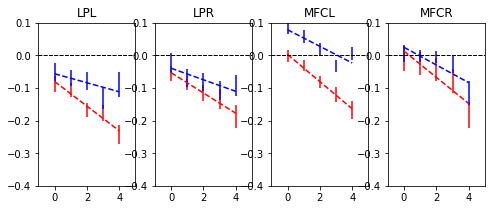

In [38]:
plt_mean_ci(x, Y, fit_DMN, mean_y_DMN, sem_y_DMN, n_dxn, 'DMN_VIS_LinearFit.eps')